In [ ]:
from pathlib import Path
import pandas as pd
import urllib.request
import seaborn as sns
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/PKU-DAIR/KnobsTuningEA/refs/heads/master/tuning_benchmark/data/SYSBENCH_5knob.csv"
data_path = Path("btl/dataset/SYSBENCH_5knob.csv")
if not data_path.is_file():
    Path("btl/dataset").mkdir(parents=True, exist_ok=True)
    urllib.request.urlretrieve(url, data_path)

configs = pd.read_csv(Path("btl/dataset/SYSBENCH_5knob.csv")).drop("Unnamed: 0", axis=1)

In [2]:
configs.head()

,max_heap_table_size,tmp_table_size,innodb_doublewrite,query_prealloc_size,innodb_thread_concurrency,tps
0,1.677722e+07,16777216.0,1,8192.0,0.0,332.721927
1,5.195222e+08,544013177.0,0,101472750.0,519.0,334.997632
2,6.141391e+08,395733510.0,0,83207073.0,614.0,343.184838
3,7.891182e+08,548395253.0,0,80583681.0,698.0,330.697227
4,1.073742e+09,508516635.0,0,110654782.0,1000.0,339.443657


In [3]:
configs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6250 entries, 0 to 6249
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   max_heap_table_size        6250 non-null   float64
 1   tmp_table_size             6250 non-null   float64
 2   innodb_doublewrite         6250 non-null   int64  
 3   query_prealloc_size        6250 non-null   float64
 4   innodb_thread_concurrency  6250 non-null   float64
 5   tps                        6250 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 293.1 KB


In [4]:
configs.describe()

,max_heap_table_size,tmp_table_size,innodb_doublewrite,query_prealloc_size,innodb_thread_concurrency,tps
count,6.250000e+03,6.250000e+03,6250.000000,6.250000e+03,6250.000000,6250.000000
mean,7.308685e+08,3.615051e+08,0.121760,8.442150e+07,331.703200,343.333771
std,2.973455e+08,3.520588e+08,0.327035,4.822343e+07,327.525321,22.516352
min,1.638400e+04,1.024000e+03,0.000000,8.192000e+03,0.000000,146.646300
25%,4.883136e+08,2.656921e+07,0.000000,4.140951e+07,45.000000,334.240530
50%,8.003769e+08,2.672265e+08,0.000000,9.771155e+07,212.000000,345.071621
75%,1.009519e+09,6.041552e+08,0.000000,1.316453e+08,495.000000,358.778557
max,1.073742e+09,1.073742e+09,1.000000,1.342177e+08,1000.000000,398.710949


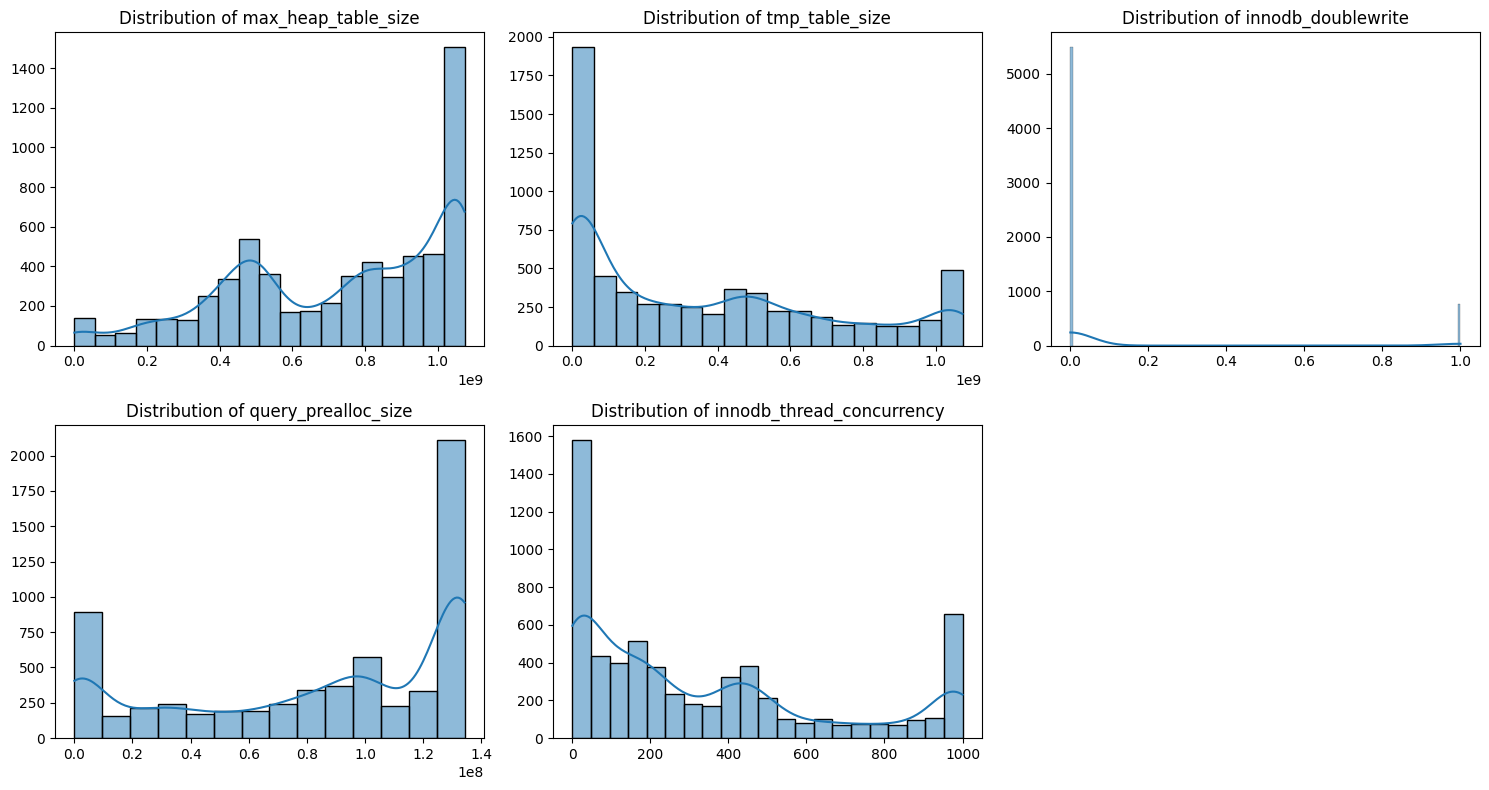

In [5]:
data_to_plot = configs.drop("tps", axis=1)

# Set up the matplotlib figure
# This creates a grid of plots. We'll calculate the number of rows needed.
n_cols = 3
n_rows = (data_to_plot.shape[1] + n_cols - 1) // n_cols  # Ceiling division
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()  # Flatten the 2D array of axes to a 1D array for easy iteration

# Loop through each column and plot its histogram
for i, col in enumerate(data_to_plot.columns):
    sns.histplot(data_to_plot[col], ax=axes[i], kde=True)
    axes[i].set_title(f"Distribution of {col}", fontsize=12)
    axes[i].set_xlabel("")  # Keep it clean
    axes[i].set_ylabel("")

# Hide any unused subplots
for i in range(len(data_to_plot.columns), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

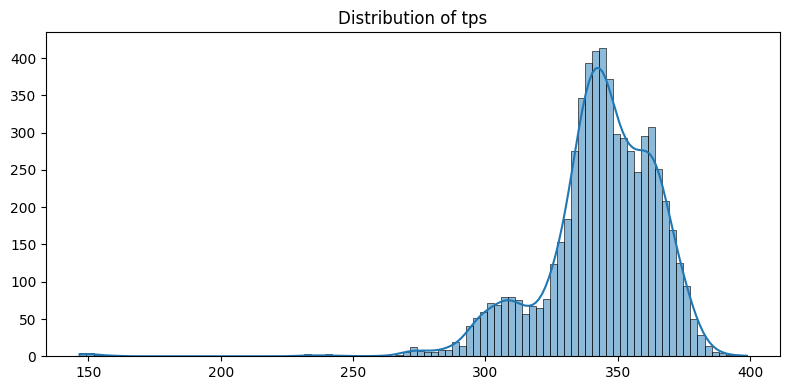

In [6]:
data_to_plot = configs["tps"].copy()

plt.figure(figsize=(8, 4))
sns.histplot(data_to_plot, kde=True)
plt.title("Distribution of tps", fontsize=12)
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.show()

In [7]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(configs, test_size=0.2, random_state=42)

innodb_doublewrite          -0.501870
innodb_thread_concurrency   -0.341746
tmp_table_size              -0.068978
query_prealloc_size          0.200513
max_heap_table_size          0.200990
Name: tps, dtype: float64


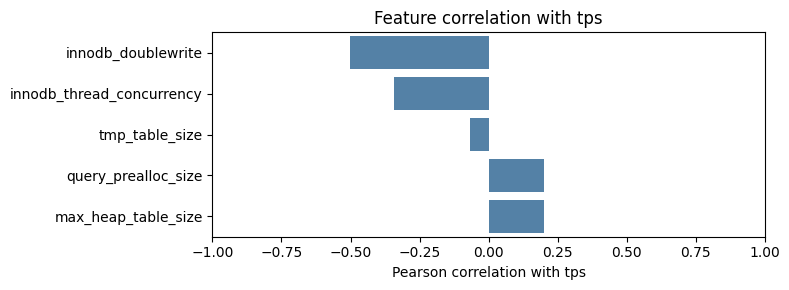

In [8]:
# 2. Statistical Investigation: Correlation plots
corr = train_set.corr(numeric_only=True)

# Feature correlations with tps (bar plot)
tps_corr = corr["tps"].drop(labels=["tps"]).sort_values()
print(tps_corr)
plt.figure(figsize=(8, max(3, 0.35 * len(tps_corr))))
sns.barplot(x=tps_corr.values, y=tps_corr.index, orient="h", color="steelblue")
plt.xlim(-1, 1)
plt.xlabel("Pearson correlation with tps")
plt.ylabel("")
plt.title("Feature correlation with tps")
plt.tight_layout()
plt.show()

In [9]:
knobs = train_set.drop("tps", axis=1)
tps = train_set["tps"].copy()
knobs_test = test_set.drop("tps", axis=1)
tps_test = test_set["tps"].copy()

In [10]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical_features = ["innodb_doublewrite"]

numerical_features = [col for col in knobs.columns if col not in categorical_features]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ],
    remainder="passthrough",
)
preprocessor.fit(knobs)

new_cat_features = preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_features)
new_feature_names = list(numerical_features) + list(new_cat_features)

knobs = pd.DataFrame(preprocessor.transform(knobs), columns=new_feature_names)  # type: ignore
knobs_test = pd.DataFrame(preprocessor.transform(knobs_test), columns=new_feature_names)  # type: ignore

In [11]:
knobs.head()

,max_heap_table_size,tmp_table_size,query_prealloc_size,innodb_thread_concurrency,innodb_doublewrite_0,innodb_doublewrite_1
0,-0.598006,-0.964375,-1.714073,1.429260,0.0,1.0
1,1.149875,1.938595,-1.752437,-1.006655,1.0,0.0
2,1.149875,-1.022418,1.024473,-1.006655,1.0,0.0
3,1.140834,0.255565,-1.738973,2.042069,1.0,0.0
4,-2.448881,-0.658194,1.024473,-1.006655,1.0,0.0


In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Let's create a dictionary to store our results for easy comparison
model_results = {}

print("--- Training Linear Regression ---")
lin_reg = LinearRegression()
lin_reg.fit(knobs, tps)

y_pred_lin = lin_reg.predict(knobs_test)

# Evaluate
lin_rmse = np.sqrt(mean_squared_error(tps_test, y_pred_lin))
lin_mae = mean_absolute_error(tps_test, y_pred_lin)
lin_r2 = r2_score(tps_test, y_pred_lin)

model_results["Linear Regression"] = {"RMSE": lin_rmse, "MAE": lin_mae, "R2": lin_r2}
print(f"Linear Regression RMSE: {lin_rmse:.2f} TPS")
print(f"Linear Regression MAE: {lin_mae:.2f} TPS")
print(f"Linear Regression R2: {lin_r2:.3f}\n")

--- Training Linear Regression ---
Linear Regression RMSE: 18.55 TPS
Linear Regression MAE: 11.41 TPS
Linear Regression R2: 0.334



In [13]:
from LinearRegression import MyLinearRegression

my_lin_reg = MyLinearRegression()
my_lin_reg.fit(knobs, tps)

y_pred_my_lin = my_lin_reg.predict(knobs_test)

my_lin_rmse = np.sqrt(mean_squared_error(tps_test, y_pred_my_lin))
my_lin_mae = mean_absolute_error(tps_test, y_pred_my_lin)
my_lin_r2 = r2_score(tps_test, y_pred_my_lin)

model_results["My Linear Regression"] = {"RMSE": my_lin_rmse, "MAE": my_lin_mae, "R2": my_lin_r2}
print(f"My Linear Regression RMSE: {my_lin_rmse:.2f} TPS")
print(f"My Linear Regression MAE: {my_lin_mae:.2f} TPS")
print(f"My Linear Regression R2: {my_lin_r2:.3f}\n")

My Linear Regression RMSE: 18.55 TPS
My Linear Regression MAE: 11.41 TPS
My Linear Regression R2: 0.334



In [14]:
# --- 2. Decision Tree Regressor ---
print("--- Training Decision Tree Regressor ---")
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(knobs, tps)

# Make predictions
y_pred_tree = tree_reg.predict(knobs_test)

# Evaluate
tree_rmse = np.sqrt(mean_squared_error(tps_test, y_pred_tree))
tree_mae = mean_absolute_error(tps_test, y_pred_tree)
tree_r2 = r2_score(tps_test, y_pred_tree)

model_results["Decision Tree"] = {"RMSE": tree_rmse, "MAE": tree_mae, "R2": tree_r2}
print(f"Decision Tree RMSE: {tree_rmse:.2f} TPS")
print(f"Decision Tree MAE: {tree_mae:.2f} TPS")
print(f"Decision Tree R2: {tree_r2:.3f}\n")

--- Training Decision Tree Regressor ---
Decision Tree RMSE: 5.86 TPS
Decision Tree MAE: 4.02 TPS
Decision Tree R2: 0.934



In [15]:
from RegressionTree import MyDecisionTreeRegressor

my_tree_reg = MyDecisionTreeRegressor()
my_tree_reg.fit(knobs, tps)

y_pred_my_tree = my_tree_reg.predict(knobs_test)

my_tree_rmse = np.sqrt(mean_squared_error(tps_test, y_pred_my_tree))
my_tree_mae = mean_absolute_error(tps_test, y_pred_my_tree)
my_tree_r2 = r2_score(tps_test, y_pred_my_tree)

model_results["My Decision Tree"] = {"RMSE": my_tree_rmse, "MAE": my_tree_mae, "R2": my_tree_r2}
print(f"My Decision Tree RMSE: {my_tree_rmse:.2f} TPS")
print(f"My Decision Tree MAE: {my_tree_mae:.2f} TPS")
print(f"My Decision Tree R2: {my_tree_r2:.3f}\n")

My Decision Tree RMSE: 5.84 TPS
My Decision Tree MAE: 4.02 TPS
My Decision Tree R2: 0.934



In [16]:
# --- 3. Random Forest Regressor ---
print("--- Training Random Forest Regressor ---")

forest_reg = RandomForestRegressor(n_estimators=1400, random_state=42, n_jobs=-1, max_depth=100, bootstrap=True)

forest_reg.fit(knobs, tps)

# Make predictions
y_pred_forest = forest_reg.predict(knobs_test)

# Evaluate
forest_rmse = np.sqrt(mean_squared_error(tps_test, y_pred_forest))
forest_mae = mean_absolute_error(tps_test, y_pred_forest)
forest_r2 = r2_score(tps_test, y_pred_forest)

model_results["Random Forest"] = {"RMSE": forest_rmse, "MAE": forest_mae, "R2": forest_r2}
print(f"Random Forest RMSE: {forest_rmse:.2f} TPS")
print(f"Random Forest MAE: {forest_mae:.2f} TPS")
print(f"Random Forest R2: {forest_r2:.3f}\n")

--- Training Random Forest Regressor ---
Random Forest RMSE: 4.03 TPS
Random Forest MAE: 3.00 TPS
Random Forest R2: 0.969



In [18]:
from RandomForest import MyRandomForestRegressor

my_forest_reg = MyRandomForestRegressor(n_estimators=10)
my_forest_reg.fit(knobs, tps)

y_pred_my_forest = my_forest_reg.predict(knobs_test)

my_forest_rmse = np.sqrt(mean_squared_error(tps_test, y_pred_my_forest))
my_forest_mae = mean_absolute_error(tps_test, y_pred_my_forest)
my_forest_r2 = r2_score(tps_test, y_pred_my_forest)

model_results["My Random Forest"] = {"RMSE": my_forest_rmse, "MAE": my_forest_mae, "R2": my_forest_r2}
print(f"My Random Forest RMSE: {my_forest_rmse:.2f} TPS")
print(f"My Random Forest MAE: {my_forest_mae:.2f} TPS")
print(f"My Random Forest R2: {my_forest_r2:.3f}\n")

My Random Forest RMSE: 4.62 TPS
My Random Forest MAE: 3.25 TPS
My Random Forest R2: 0.959



In [19]:
print("--- Model Comparison ---")
results_df = pd.DataFrame(model_results).T.sort_values(by="R2", ascending=False)
display(results_df)

--- Model Comparison ---


,RMSE,MAE,R2
Random Forest,4.032079,3.003549,0.968547
My Random Forest,4.621937,3.254399,0.958671
My Decision Tree,5.838199,4.018004,0.934058
Decision Tree,5.857107,4.024963,0.933630
My Linear Regression,18.552848,11.412224,0.334072
Linear Regression,18.552848,11.412224,0.334072


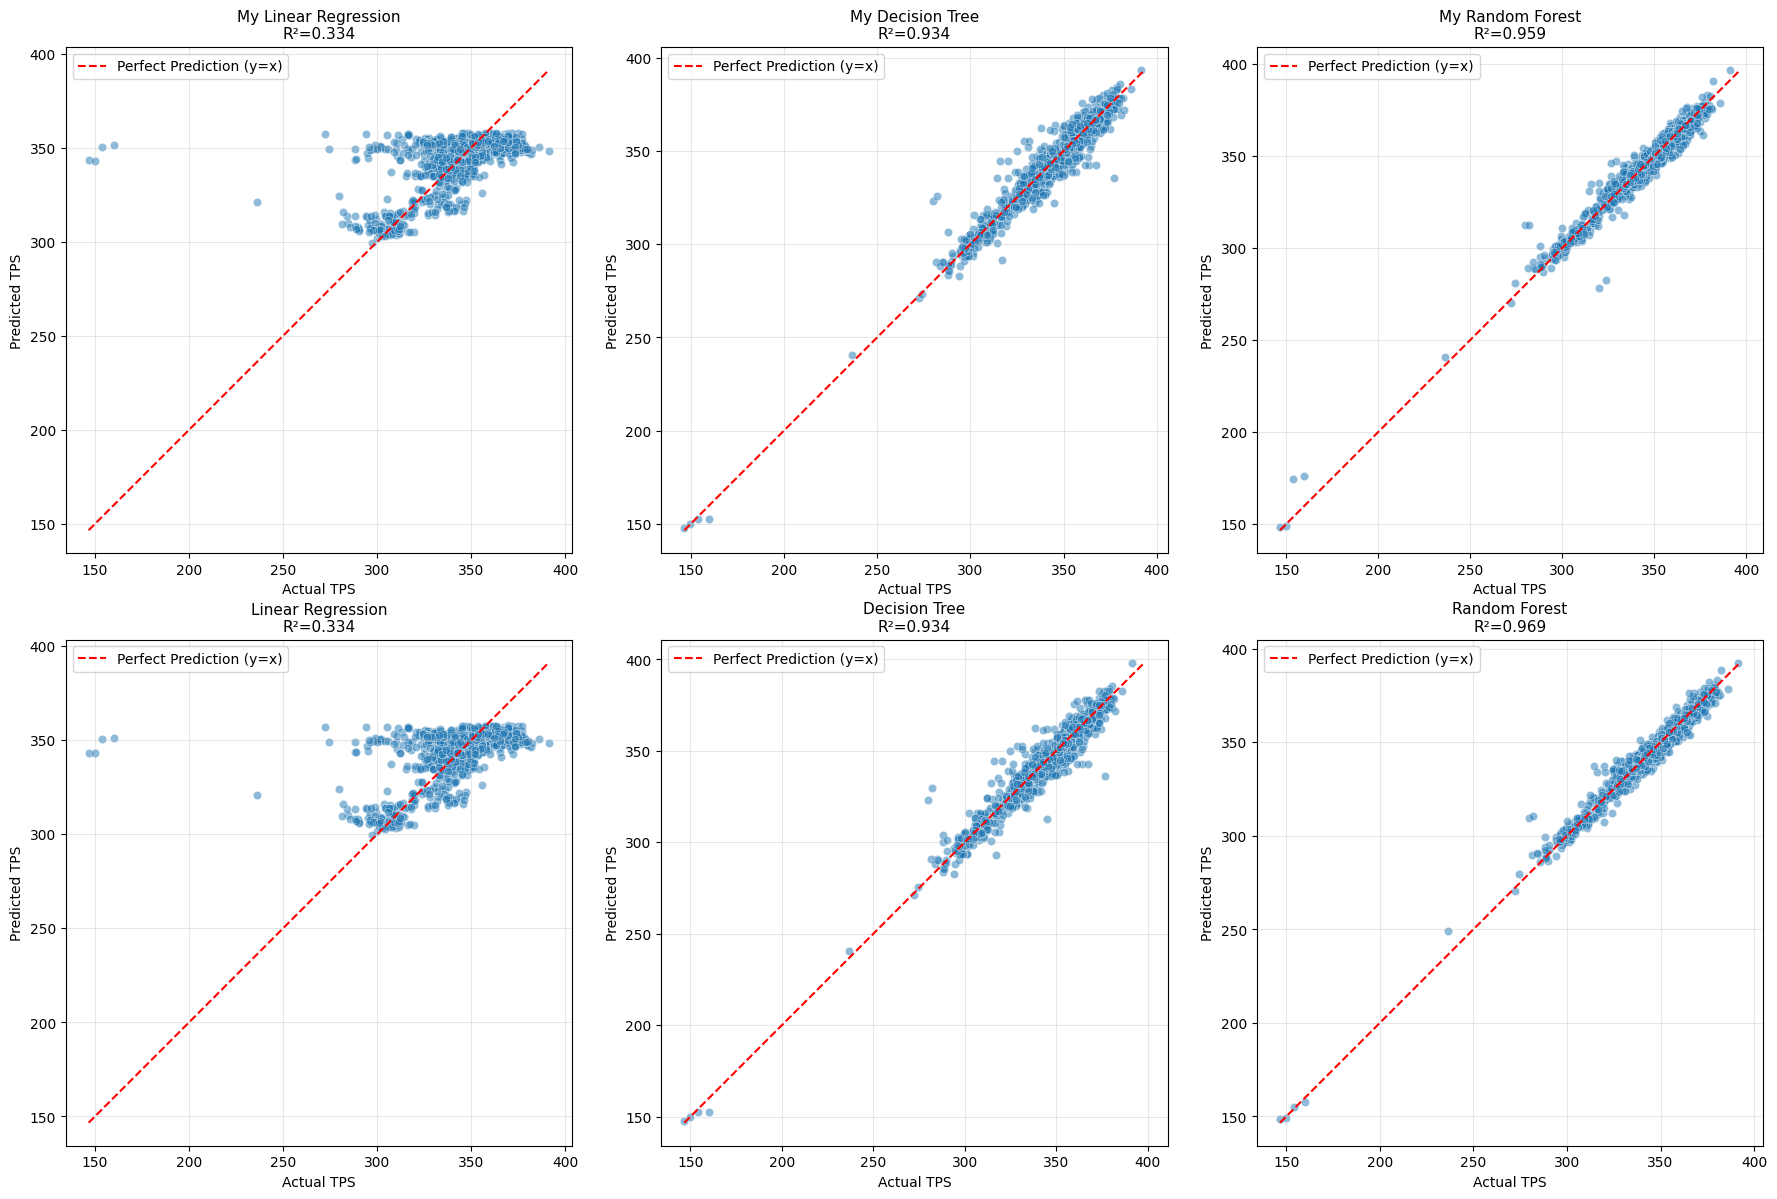

In [ ]:
predictions = {
    "My Linear Regression": y_pred_my_lin,
    "My Decision Tree": y_pred_my_tree,
    "My Random Forest": y_pred_my_forest,
    "Linear Regression": y_pred_lin,
    "Decision Tree": y_pred_tree,
    "Random Forest": y_pred_forest,
}

# Create subplots for all models
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (model_name, y_pred) in enumerate(predictions.items()):
    ax = axes[idx]

    # Scatter plot
    sns.scatterplot(x=tps_test, y=y_pred, alpha=0.5, ax=ax)

    # Add 45-degree line for perfect prediction
    lims = [min(tps_test.min(), y_pred.min()), max(tps_test.max(), y_pred.max())]
    ax.plot(lims, lims, "r--", label="Perfect Prediction (y=x)")

    ax.set_xlabel("Actual TPS", fontsize=10)
    ax.set_ylabel("Predicted TPS", fontsize=10)
    ax.set_title(f"{model_name}\nR²={model_results[model_name]['R2']:.3f}", fontsize=11)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_aspect("equal", adjustable="box")

plt.tight_layout()
plt.show()